In [1]:
from matplotlib.pylab import *
from matplotlib import pyplot as plt
import numpy as np
import cv2
from collections import defaultdict

1. Считать цветное rgb изображение

In [2]:
def plt_show_img(img, is_gray = True):
    axis("off")
    imshow(img, cmap = plt.get_cmap('gray') if is_gray else None)

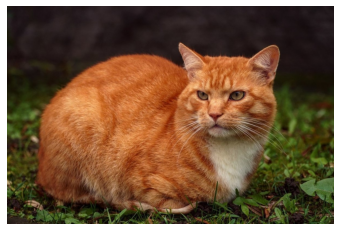

In [3]:
IMG_PATH = "./kitty4.jpg"

img = cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB)
plt_show_img(img, False)

In [4]:
img.shape

(800, 1200, 3)

2. Преобразовать изображение в градации серого

Формула преобразования: __Y = 0.2126 * R + 0.7152 * G + 0.0722 * B__

In [8]:
def img_to_grayscale(rgb_img):
    return (rgb_img[:,:,0]*0.2126 + rgb_img[:,:,1]*0.7152 + rgb_img[:,:,2]*0.0722).astype(np.uint8)

In [9]:
img_gray = img_to_grayscale(img)

In [10]:
%matplotlib inline

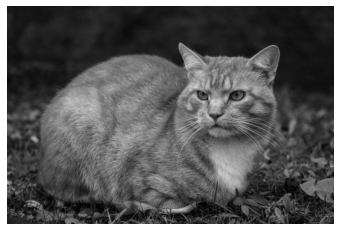

In [11]:
plt_show_img(img_gray)

3. Написать функцию реализации препарирования изображения

In [38]:
def img_prepare_func(img, s=64, r=256):
    return (img.copy() % s) * int(r/s)

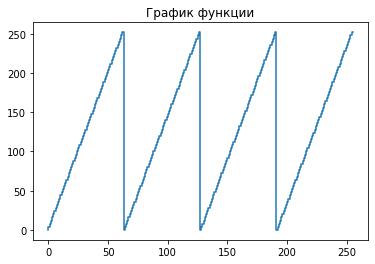

In [55]:
x_list = np.arange(256)
y_list = img_prepare_func(x_list)
plt.title('График функции')
plt.step(x_list, y_list)
show()

4. По гистограмме изображения определить значение порога яркостей, обеспечивающего оптимальное разделение объекта и фона. Осуществить пороговую обработку входного изображения с найденным пороговым значением:

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно
    - Порог определить на глаз по гистограмме

In [14]:
def get_img_values(img, nbr_bins = 256, plot_cdf = False):
    if len(img.shape) < 2:
        return
    img_hist, bins = np.histogram(img.flatten(), nbr_bins, [0, 256])
    cdf = img_hist.cumsum()
    norm_cdf = cdf * float(img_hist.max()) / cdf.max()
    return img_hist, bins, cdf, norm_cdf
    
def plot_img_values(img, norm_cdf = None, nbr_bins = 256, plot_title = None, should_plot_cdf = False):
    figure(figsize=(10, 5))
    if plot_title:
        title(plot_title)
    if should_plot_cdf:
        plot(norm_cdf, color='b')  
        hist(img.flatten(), nbr_bins, [0, 256], color='r')
        xlim([0, 256])
        legend(("функция распределения", "гистограмма"), loc="upper left")
    else:
        hist(img.flatten(), bins=nbr_bins, density=True)
    grid(True)
    show()

In [15]:
def threshold_prep(img_grayscale, threshold = 100):
    img_threshold = img_grayscale.copy()
    img_threshold[img_threshold < threshold] = 0
    return img_threshold

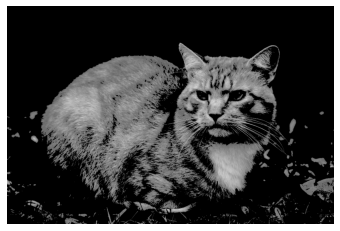

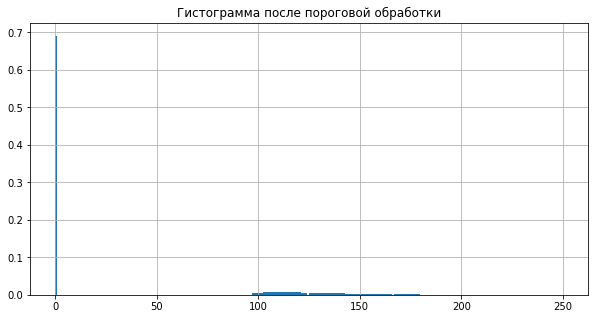

In [54]:
img_threshold = threshold_prep(img_gray, threshold=97)
plt_show_img(img_threshold)
plot_img_values(img_threshold, plot_title="Гистограмма после пороговой обработки")

Задание 5. Сделать пороговую обработку методом `Otsu` (Функция OpenCV)
 - __Вход:__ изображение из пункта 2
 - __Вывод:__ входное и результирующие изображение и их гистограммы соответственно

In [19]:
_, opencv_threshold_img = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU)

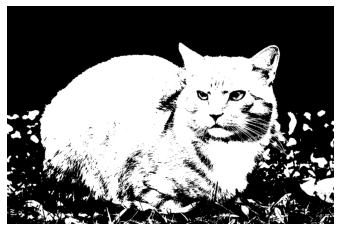

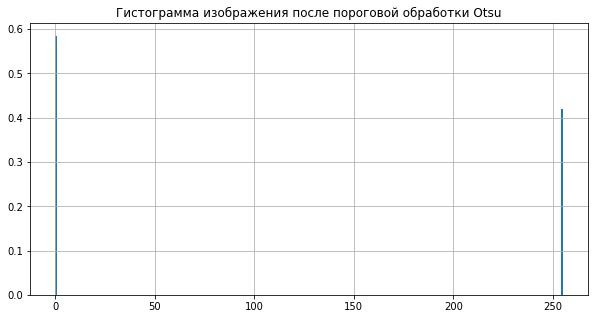

In [20]:
plt_show_img(opencv_threshold_img)
plot_img_values(opencv_threshold_img, plot_title="Гистограмма изображения после пороговой обработки Otsu")

Задание 6. Определить динамический диапазон входного изображения. Осуществить линейное контрастирование входного изображения в заданный динамический диапазон яркостей
 - __Вход:__ изображение у которого диапазон не на всем промежутке [0,255]
 - __Вывод:__ входное и результирующие изображение и их гистограммы соответственно
 - Вычислить коэффициенты $ a $ и $ b $. Сделать преобразование вида: $ g =a * f + b $

In [21]:
def linear_contrast(img_grayscale):
    results = defaultdict(lambda: None)

    flatten_img = img_grayscale.flatten()
    x_min = flatten_img.min()
    x_max = flatten_img.max()
    results["original_range"] = (x_min, x_max)
    results["original_image"] = img_grayscale.copy()

    y_min = 0
    y_max = 255
    a = (y_max - y_min) / (x_max - x_min)
    b = (y_min * x_max - y_max * x_min) / (x_max - x_min)
    results["a"] = a
    results["b"] = b

    img_result = (a * img_grayscale.copy() + b).astype(np.uint8)

    flatten_img_result = img_result.flatten()
    results["result_range"] = (flatten_img_result.min(), flatten_img_result.max())
    results["result_image"] = img_result

    return results

In [25]:
img_man = cv2.imread("./man.png", cv2.IMREAD_GRAYSCALE)
linear_contrast_result = linear_contrast(img_man)

In [26]:
print("Линейное преобразование для данного изображения: f =", linear_contrast_result['a'], "* x +", linear_contrast_result['b'])

Линейное преобразование для данного изображения: f = 2.802197802197802 * x + -260.6043956043956


Динамический диапазон исходного изображения: (93, 184)


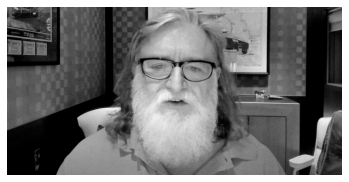

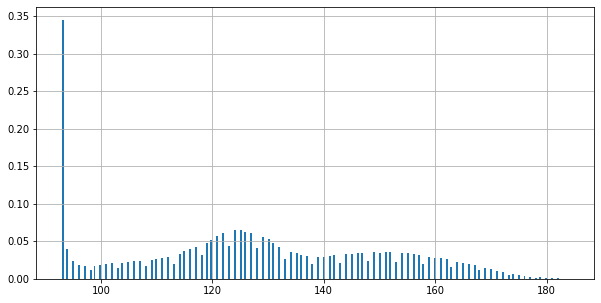

In [27]:
print("Динамический диапазон исходного изображения:", linear_contrast_result['original_range'])
plt_show_img(linear_contrast_result['original_image'])
_, _, _, norm_cdf = get_img_values(linear_contrast_result['original_image'])
plot_img_values(linear_contrast_result['original_image'])
#get_values_and_plot(linear_contrast_result['original_image'])

Динамический диапазон после линейного контрастирования: (0, 254)


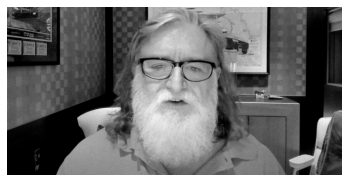

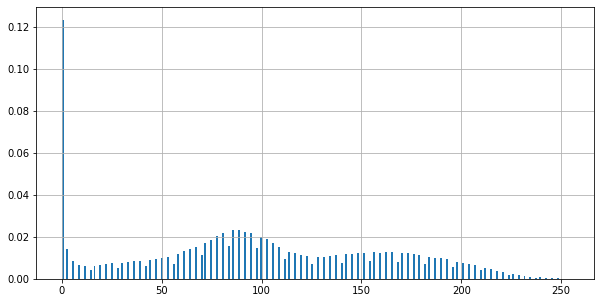

In [28]:
print("Динамический диапазон после линейного контрастирования:", linear_contrast_result['result_range'])
plt_show_img(linear_contrast_result['result_image'])
plot_img_values(linear_contrast_result['result_image'])

7. Сделать эквализацию гистограммы изображения

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно

In [46]:
def img_eq(img_grayscale, cdf):
    cdf_mask = np.ma.masked_equal(cdf, 0)
    cdf_mask = ((cdf_mask - cdf_mask.min()) * 255 / (cdf_mask.max() - cdf_mask.min()))
    result_cdf = np.ma.filled(cdf_mask, 0).astype(np.uint8)
    result_img = result_cdf[img_grayscale]
    return result_img

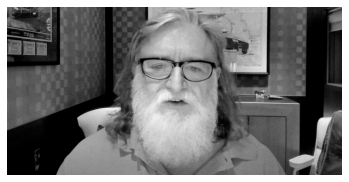

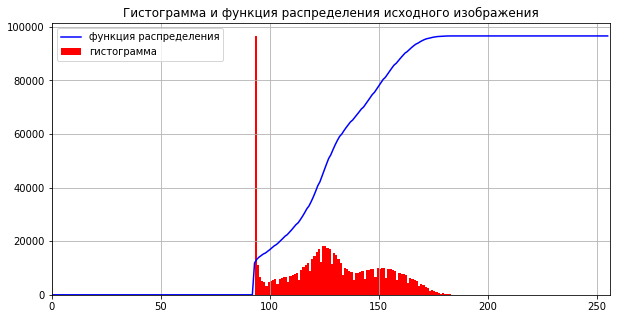

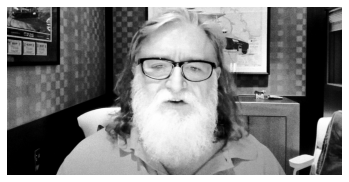

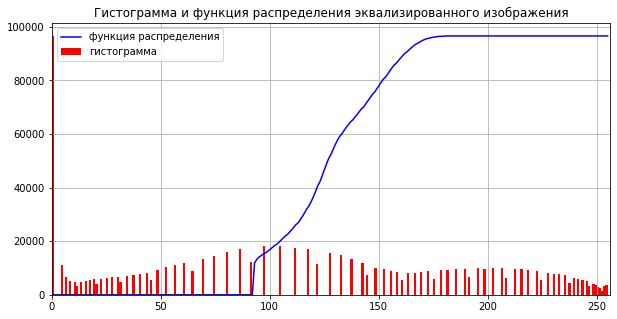

In [47]:
_, _, cdf, norm_cdf = get_img_values(img_man)
plt_show_img(img_man)
plot_img_values(img_man, norm_cdf, plot_title="Гистограмма и функция распределения исходного изображения", should_plot_cdf=True)
img_equal = img_eq(img_man, cdf)
plt_show_img(img_equal)
plot_img_values(img_equal, norm_cdf, plot_title="Гистограмма и функция распределения эквализированного изображения", should_plot_cdf=True)

8. Сделать эквализацию методом CLAHE (Функция OpenCV)

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно

In [32]:
img_equal_opencv = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img_man)

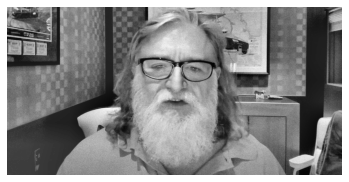

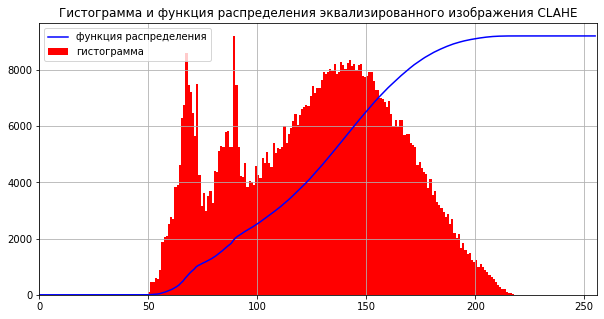

In [34]:
plt_show_img(img_equal_opencv)
_, _, cdf, norm_cdf = get_img_values(img_equal_opencv)
plot_img_values(img_equal_opencv, norm_cdf, plot_title="Гистограмма и функция распределения эквализированного изображения CLAHE", should_plot_cdf=True)

9. Осуществить препарирование изображения с заданной препарирующей функцией

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно. График препарирующий функции.
    - Пороги в препарирующей функции выбирать самостоятельно

In [35]:
def img_preparation(img_grayscale, prep_func):
    return prep_func(img_grayscale.copy()).astype(np.uint8)

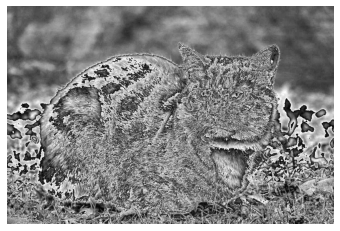

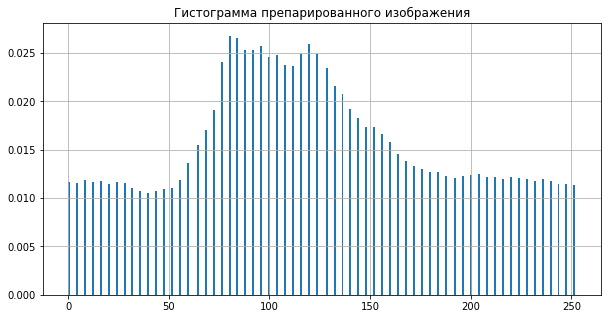

In [37]:
img_prepared = img_preparation(img_gray, img_prepare_func)
_, _, cdf, norm_cdf = get_img_values(img_prepared)
plt_show_img(img_prepared)
plot_img_values(img_prepared, plot_title="Гистограмма препарированного изображения")